In [9]:
from scipy import stats
import pandas as pd
import numpy as np
from pandas import concat
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import warnings
import numpy as np
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [2]:
X = pd.read_csv('data/datos_diarios_PVPC_demanda_carburantes.csv')[['Fecha','PVPC_Llano', 'PVPC_Punta', 'PVPC_Valle']].reset_index(drop = True)
X['Fecha'] = pd.to_datetime(X['Fecha'])
X = X.sort_values(by = 'Fecha', ascending = False)
X.set_index('Fecha', inplace=True)
X

,PVPC_Llano,PVPC_Punta,PVPC_Valle
Fecha,,,
2024-08-31,145.091315,145.091315,145.091315
2024-08-30,199.630289,238.391201,150.595214
2024-08-29,202.326771,235.875252,154.862677
2024-08-28,187.933779,236.859297,147.329026
2024-08-27,185.990232,241.149503,144.445452
...,...,...,...
2022-10-05,337.913411,453.173332,359.987677
2022-10-04,371.324199,494.452371,362.289320
2022-10-03,351.282714,432.649761,319.078946


PVPC_Llano


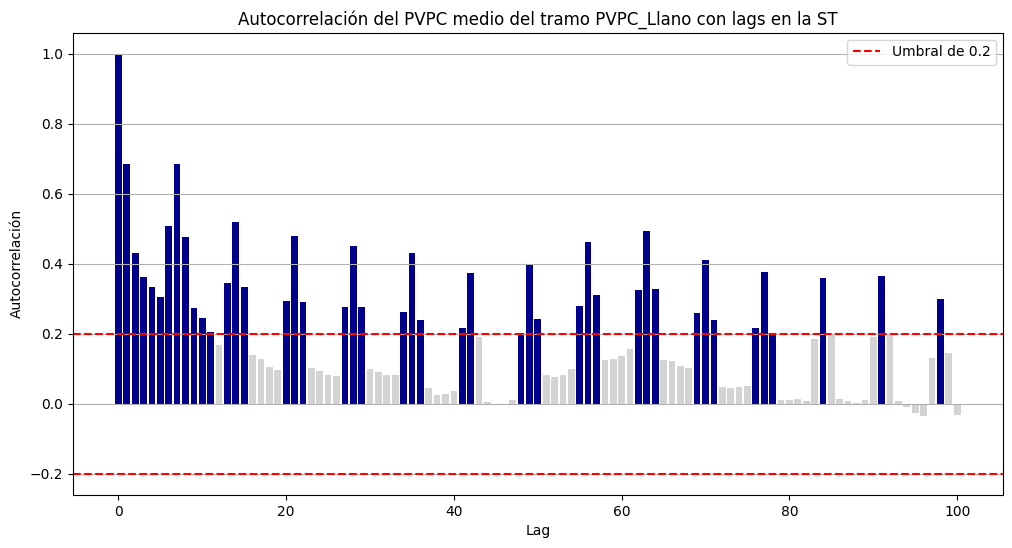

PVPC_Punta


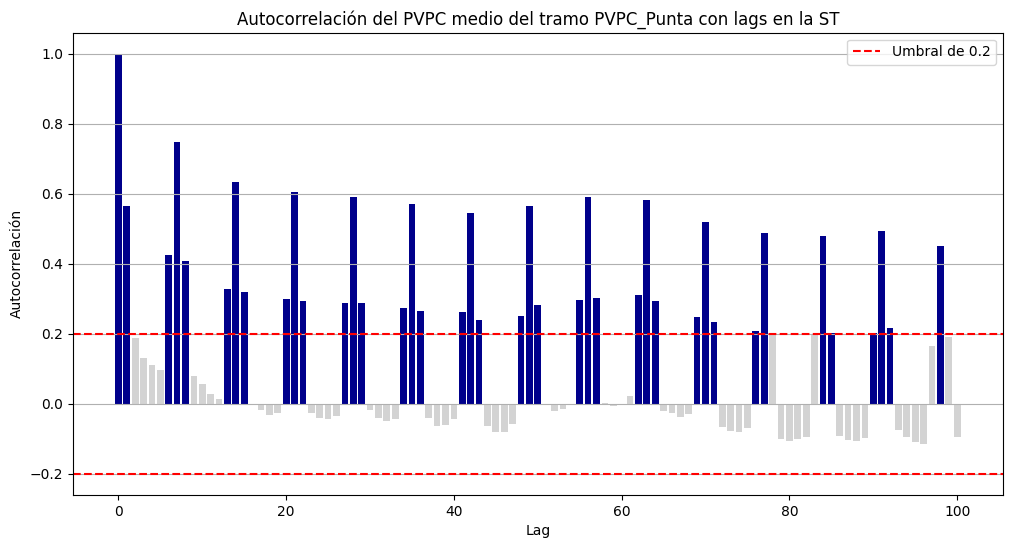

PVPC_Valle


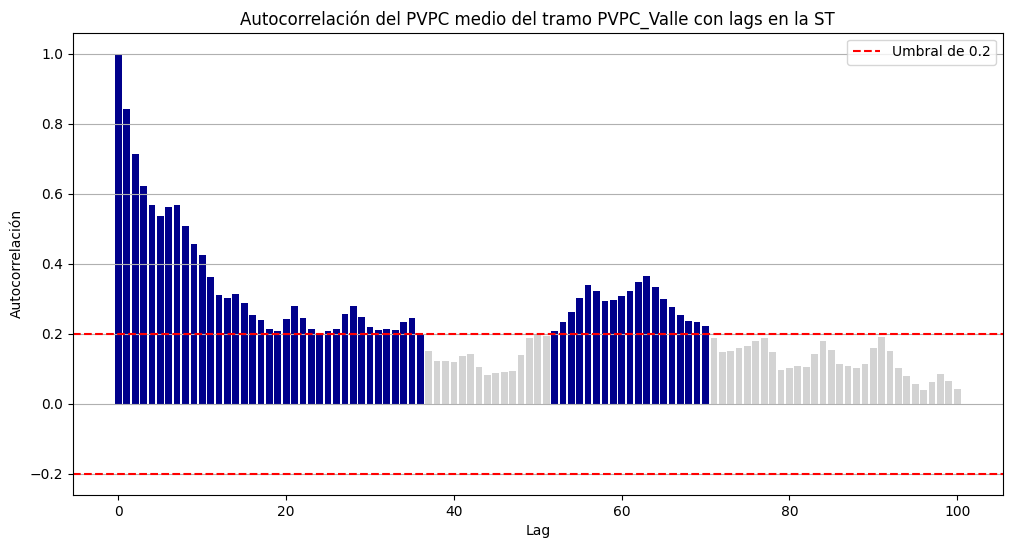

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

for i in X.columns:
    print(i)
    X_copy = X[i].values
    # Calcular la autocorrelación
    n_lags = 100  # Número de lags que deseas considerar
    autocorr_values = acf(X_copy, nlags=n_lags)

    autocorr_df = pd.DataFrame({'Lag': range(n_lags + 1), 'Autocorrelation': autocorr_values})

    #autocorr_df['Date'] = [X.index[lag] if lag < len(X.index) else None for lag in autocorr_df['Lag']]
    #autocorr_df['Is_Weekend'] = autocorr_df['Date'].apply(lambda date: date.weekday() >= 5 if date is not None else None)

    # Filtrar para encontrar los lags con autocorrelación significativa
    threshold = 0.2
    autocorr_df['Significant'] = autocorr_df['Autocorrelation'].abs() > threshold
    #print(autocorr_df[(autocorr_df['Significant']) & (autocorr_df['Lag'] > 0)])

    autocorr_df[(autocorr_df['Significant']) & (autocorr_df['Lag'] > 0)].to_csv(f'lags_significativos_tramo_{i}.csv', index = False)

    plt.figure(figsize=(12, 6))

    # Colorear según la significancia
    colors = ['lightgray' if not sig else 'darkblue' for sig in autocorr_df['Significant']]

    plt.bar(autocorr_df['Lag'], autocorr_df['Autocorrelation'], color=colors)

    plt.title(f'Autocorrelación del PVPC medio del tramo {i} con lags en la ST')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelación')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Umbral de 0.2')  # Línea del umbral
    plt.axhline(y=-threshold, color='red', linestyle='--')  # Línea del umbral negativo
    plt.legend()
    plt.grid(axis='y')

    # Mostrar el gráfico
    plt.show()

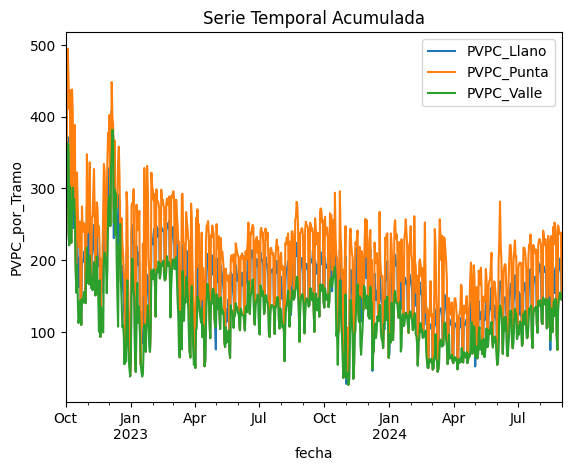

In [4]:
# Graficar la serie temporal acumulada
X.plot()
plt.title('Serie Temporal Acumulada')
plt.xlabel('fecha')
plt.ylabel('PVPC_por_Tramo')
plt.show()

In [5]:
# Desplaza los datos de la serie temporal por una frecuencia semanal
X.shift(1)
print(X.head(8))

# Función para generar atributos de desfase
def generar_atributos_desface(ts_data, var, max_lag):
    for t in range(1, max_lag+1):
        # Crea una nueva columna en el DataFrame con el desfase de la variable especificada
        ts_data[var+'_lag'+str(t)] = ts_data[var].shift(t)

X2 = X.copy()
for col in X2.columns:
    generar_atributos_desface(X2, col, max_lag=8)

            PVPC_Llano  PVPC_Punta  PVPC_Valle
Fecha                                         
2024-08-31  145.091315  145.091315  145.091315
2024-08-30  199.630289  238.391201  150.595214
2024-08-29  202.326771  235.875252  154.862677
2024-08-28  187.933779  236.859297  147.329026
2024-08-27  185.990232  241.149503  144.445452
2024-08-26  181.693657  248.307124  130.205155
2024-08-25   75.037005   75.037005   75.037005
2024-08-24   96.678127   96.678127   96.678127


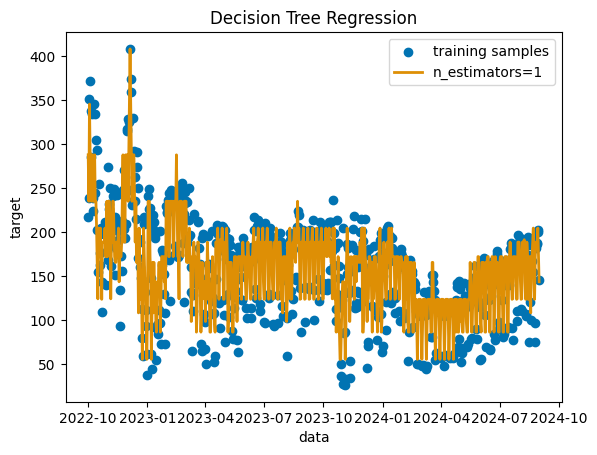

In [10]:
atributos = ['PVPC_Llano_lag1', 'PVPC_Llano_lag2', 'PVPC_Llano_lag3', 'PVPC_Llano_lag4', 'PVPC_Llano_lag5', 'PVPC_Llano_lag6', 'PVPC_Llano_lag7', 'PVPC_Llano_lag8']
att = X2.loc[:, atributos]

tg = X2.loc[:,['PVPC_Llano']]

att
regressor = DecisionTreeRegressor(random_state=0)
cross_val_score(regressor, att, tg, cv=10)

regr_1 = DecisionTreeRegressor(max_depth=4)
regr_1.fit(att, tg)
tg_1 = regr_1.predict(att)
colors = sns.color_palette("colorblind")
plt.figure()
plt.scatter(X2.index, tg, color=colors[0], label="training samples")
plt.plot(X2.index, tg_1, color=colors[1], label="n_estimators=1", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

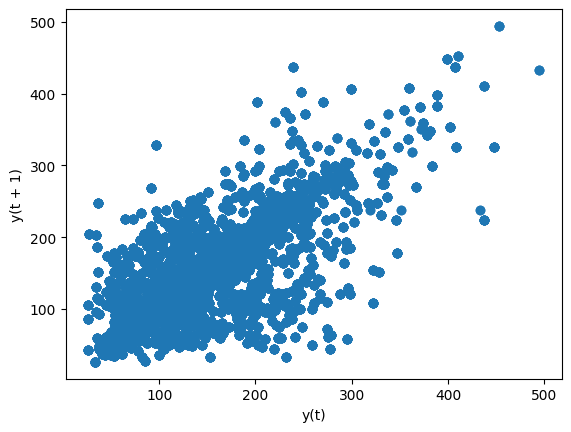

In [11]:
%matplotlib inline
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

from pandas.plotting import lag_plot
plt.figure()
lag_plot(X2)

(-0.5, 0.5)

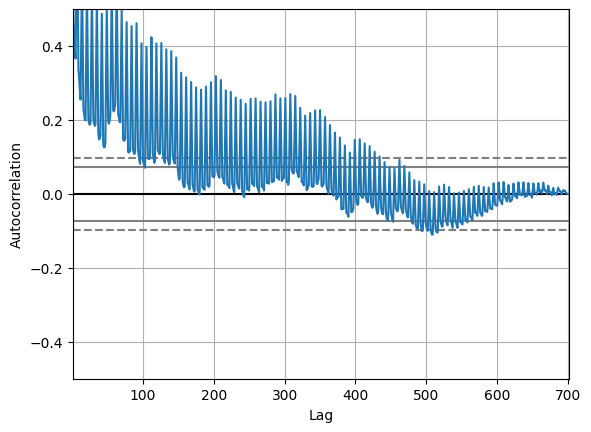

In [12]:
pd.plotting.autocorrelation_plot(X)

plt.ylim(-0.5, 0.5)

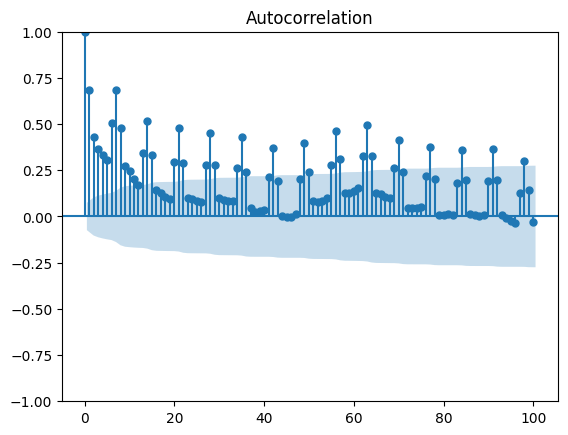

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(X['PVPC_Llano'], lags=100)

plt.show()

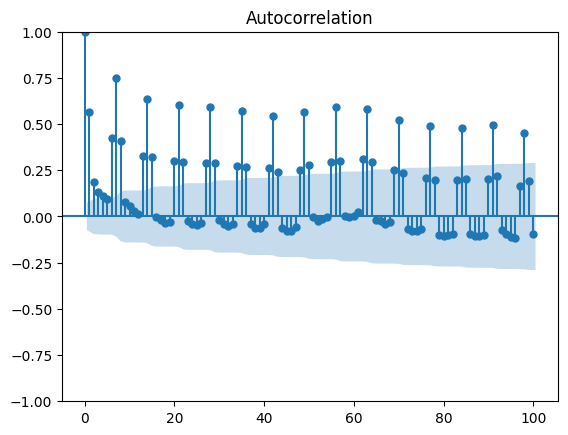

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(X['PVPC_Punta'], lags=100)

plt.show()

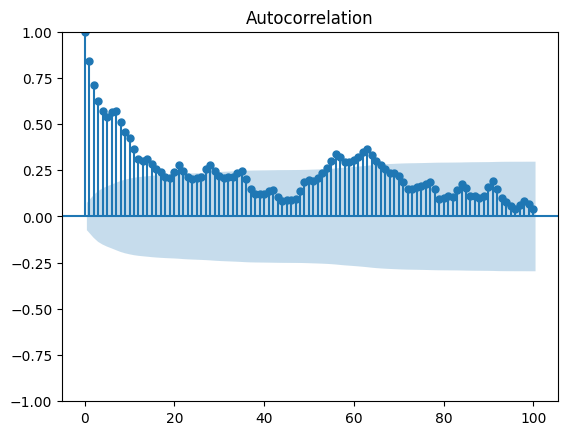

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(X['PVPC_Valle'], lags=100)

plt.show()